In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive"

 gaussian_noise.html	    nephub.gscript	    vida.html
'Genetic Algorithm.ipynb'   saftey		    visitnepal2020
'Getting started.pdf'	    sigmoid.html
 marble			    training_example.html


In [ ]:
!cp -r "/content/drive/My Drive/marble" "marble"

In [ ]:
!ls "/content/marble"

'CNN Models.ipynb'   inception.h5       resnet50.h5   vgg19.h5
 GA.h5		    'marble datasets'   vgg16.h5


In [ ]:
# create final dataset.the training  dataset consits of (0.8 * 0.8 * T), the valdation dataset (0.2 * 0.8 * T) and (0.2 * T) testing images.
# x_train: Numpy arrays of the images of the training dataset
# y_train: Labels of the training dataset
# x_test: Numpy arrays of the images of the testing dataset
# y_test: Labels of the testing dataset
# x_val: Numpy arrays of the images of the validation dataset
# y_val: Labels of the validation dataset

from tensorflow.keras.layers import  Convolution2D, MaxPooling2D, Input, Lambda, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report

import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob

#count the number of images in respective directory
import fnmatch
print( "Total number of images in CLASS A", len(fnmatch.filter(os.listdir("/content/marble/marble datasets/CLASS A"), '*.jpg')));
print( "Total number of images in CLASS B", len(fnmatch.filter(os.listdir("/content/marble/marble datasets/CLASS B"), '*.jpg')));
print( "Total number of images in CLASS C", len(fnmatch.filter(os.listdir("/content/marble/marble datasets/CLASS C"), '*.jpg')));

Total number of images in CLASS A 164
Total number of images in CLASS B 245
Total number of images in CLASS C 494


In [ ]:
# split dataset into train_test_folder
! pip install python_splitter 
import python_splitter
python_splitter.split_from_folder("/content/marble/marble datasets", train=0.64, test=0.16, val=0.2)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
✅Checking SOURCE directory...
0.64 0.2 0.16
✅Checking percentage validation...
✅Making required directories...
✅Shuffling data...
✅Getting ready for copying files...

-------------Successfully splitted !!!--------------- 


In [ ]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  # crawls inside folders
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count
train_dir ="Train_Test_Folder/train"
test_dir="Train_Test_Folder/test"

In [ ]:
#train file image count
train_samples =get_files(train_dir)
#to get tags
num_classes=len(glob.glob(train_dir+"/*")) 
#test file image count
test_samples=get_files(test_dir)
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

3 Classes
576 Train images
181 Test images


In [ ]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )
test_datagen=ImageDataGenerator(rescale=1./255)


In [ ]:
input_shape=(224,224,3)
train_generator =train_datagen.flow_from_directory(train_dir,target_size=(224,224),batch_size=32)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,target_size=(224,224),batch_size=32)

Found 576 images belonging to 3 classes.
Found 181 images belonging to 3 classes.


In [ ]:
def create_Base_model_from_InceptionV3():
    IMAGE_SIZE = [224, 224]
    model_inceptionV3 = InceptionV3( 
        weights = "imagenet",# control point from which model is started
        include_top=False, # to include/exclude the first 3 layers
        input_shape = IMAGE_SIZE + [3],)
    # We don't need to train existing weights
    for layer in model_inceptionV3.layers:
        layer.trainable = False
    return model_inceptionV3

In [ ]:
inception = create_Base_model_from_InceptionV3();
x = Flatten()(inception.output)
prediction = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=inception.input, outputs=prediction)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
def create_Base_model_from_VGG16():  
    model = VGG16(
        weights = "imagenet",
        include_top=False, 
        input_shape = (224,224, 3) # goruntu boyutu
        ) 
    for layer in model.layers:
      layer.trainable = False
    return model 

In [ ]:
def add_custom_layers_VGG16():
    model = create_Base_model_from_VGG16()
    x = model.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    predictions = tf.keras.layers.Dense(num_classes, activation="softmax")(x)   
    # creating the final model 
    final_model = tf.keras.models.Model(
        inputs = model.input, 
        outputs = predictions)
     
  
    return final_model

# add_custom_layers_VGG16().summary()

In [ ]:
def create_Base_model_from_VGG19():  
    model_vgg19 = VGG19(
        weights = "imagenet",# control point from which model is started
        include_top=False, # to include/exclude the first 3 layers
        input_shape = (224,224, 3)) # image size
    # don't train existing weights 
    for layer in model_vgg19.layers:
      layer.trainable = False
    return model_vgg19 
# create_Base_model_from_VGG19().summary()

In [ ]:
def add_custom_layers_vgg19():
    #Adding custom Layers 
    model_vgg19 = create_Base_model_from_VGG19()
    x = model_vgg19.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    predictions = tf.keras.layers.Dense(num_classes, activation="softmax")(x)   
    # creating the final model 
    final_model = tf.keras.models.Model(
        inputs = model_vgg19.input, 
        outputs = predictions)
     
    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
    return final_model

# add_custom_layers_vgg19().summary()

In [ ]:
def create_Base_model_from_ResNet50():
    model_resNet50 = ResNet50( 
        weights = "imagenet",# control point from which model is started
        include_top=False,
        pooling='avg',
        input_shape = (224,224, 3))
    # We don't need to train existing weights
    model_resNet50.trainable = False
    return model_resNet50


pretrained_model= create_Base_model_from_ResNet50()
inputs = pretrained_model.input

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:

def alexnet():
    #Adding custom Layers 
    # Initializing the CNN
    model = Sequential()
    # Convolution Step 1
    model.add(Convolution2D(96, 11, strides = (4, 4), padding = 'valid', input_shape=(224, 224, 3), activation = 'relu'))
    # Max Pooling Step 1
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
    model.add(BatchNormalization())
    # Convolution Step 2
    model.add(Convolution2D(256, 11, strides = (1, 1), padding='valid', activation = 'relu'))
    # Max Pooling Step 2
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))
    model.add(BatchNormalization())
    # Convolution Step 3
    model.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
    model.add(BatchNormalization())
    # Convolution Step 4
    model.add(Convolution2D(384, 3, strides = (1, 1), padding='valid', activation = 'relu'))
    model.add(BatchNormalization())
    # Convolution Step 5
    model.add(Convolution2D(256, 3, strides=(1,1), padding='valid', activation = 'relu'))
    # Max Pooling Step 3
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
    model.add(BatchNormalization())
    # Flattening Step
    model.add(Flatten())
    # Full Connection Step
    model.add(Dense(units = 4096, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(units = 4096, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(units = 1000, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(units = num_classes, activation = 'softmax'))
    
    return model

# add_custom_layers_vgg19().summary()

In [ ]:
# model = add_custom_layers_vgg19()
# model = add_custom_layers()
# model = alexnet()
# model = add_custom_layers_VGG16()
model = create_Base_model_from_ResNet50()

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
validation_generator = train_datagen.flow_from_directory(
                       test_dir,
                       target_size=(224, 224),
                       batch_size=32)

Found 181 images belonging to 3 classes.


In [ ]:
train_generator =train_datagen.flow_from_directory(train_dir,target_size=(224,224),batch_size=32)

Found 576 images belonging to 3 classes.


In [ ]:
# uncomment it for ResNet50
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# my_callbacks  = [EarlyStopping(monitor='val_loss',min_delta=0,patience=3,mode='auto')]
# history = model.fit(
#     train_generator,
#     validation_data=validation_generator,
#     epochs=20,
#     callbacks=my_callbacks,
#     verbose=1,
#     steps_per_epoch=None,
#     validation_steps=4
# )

history = model.fit(
            train_generator,#egitim verileri
            steps_per_epoch=None,
            epochs=20, #use 5 for vgg16
            validation_data=validation_generator,
            validation_steps=None,
            verbose=1,
            callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
            shuffle=True
            )

Epoch 1/20
18/18 [==============================] - 89s 5s/step - loss: 1.0461 - accuracy: 0.5017 - val_loss: 0.9255 - val_accuracy: 0.5781
Epoch 2/20
18/18 [==============================] - 81s 5s/step - loss: 0.9483 - accuracy: 0.5486 - val_loss: 0.9407 - val_accuracy: 0.5312
Epoch 3/20
18/18 [==============================] - 82s 5s/step - loss: 0.9145 - accuracy: 0.5503 - val_loss: 0.8943 - val_accuracy: 0.6016
Epoch 4/20
18/18 [==============================] - 81s 5s/step - loss: 0.8778 - accuracy: 0.5764 - val_loss: 0.8143 - val_accuracy: 0.5625
Epoch 5/20
18/18 [==============================] - 81s 5s/step - loss: 0.8865 - accuracy: 0.5486 - val_loss: 0.8419 - val_accuracy: 0.5156
Epoch 6/20
18/18 [==============================] - 81s 5s/step - loss: 0.8333 - accuracy: 0.5660 - val_loss: 0.7644 - val_accuracy: 0.6328
Epoch 7/20
18/18 [==============================] - 82s 5s/step - loss: 0.7928 - accuracy: 0.6024 - val_loss: 0.8092 - val_accuracy: 0.5000
Epoch 8/20
18/18 [==

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
model = load_model("GA.h5")


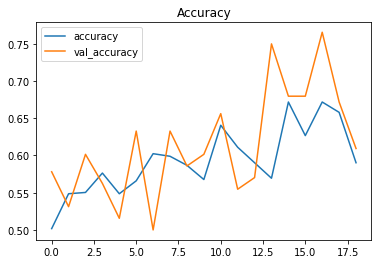

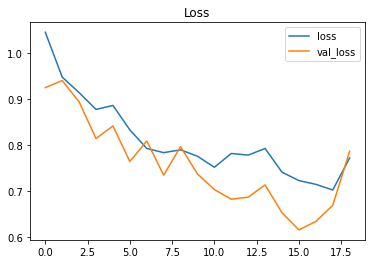

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
6/6 [==============================] - 26s 3s/step - loss: 0.0903 - accuracy: 0.9558
Test Accuracy: 95.58011293411255


In [ ]:
predicted_classes = model.predict(test_generator)
predicted_classes = np.argmax(predicted_classes, axis=1)

num_classes = 3
train_y=test_generator.classes
target_names = [f"Class {i}" for i in range(num_classes)]

print(classification_report(train_y, predicted_classes, target_names = target_names))

6/6 [==============================] - 19s 3s/step
              precision    recall  f1-score   support

     Class 0       0.18      0.18      0.18        33
     Class 1       0.32      0.31      0.31        49
     Class 2       0.51      0.53      0.52        99

    accuracy                           0.40       181
   macro avg       0.34      0.34      0.34       181
weighted avg       0.40      0.40      0.40       181



In [ ]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(train_y,  model.predict(test_generator), multi_class='ovo'));
# print(model.evaluate(test_x, test_y, verbose=0)[0])

6/6 [==============================] - 19s 3s/step
0.5089385922719255


In [ ]:
model.save('resnet50.h5')

1/1 [==============================] - 1s 1s/step
CLASS A


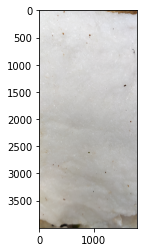

In [ ]:
classes=list(train_generator.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
img_url='Train_Test_Folder/val/CLASS A/IMG_20220811_093439_1.jpg'
model_result = model.predict([prepare(img_url)])
disease=image.load_img(img_url)
plt.imshow(disease)

classresult=np.argmax(model_result,axis=1)
print(classes[classresult[0]])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

def init():
    # our layers - you can add more if you want
    model = add_custom_layers_VGG16()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model


def train(models):
    losses = []
    early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
    for i in range(len(models)):
        history =  models[i].fit(
                    train_generator,#egitim verileri
                    steps_per_epoch=None,
                    epochs=2, #use 5 for vgg16
                    validation_data=validation_generator,
                    validation_steps=None,
                    verbose=1,
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
                    shuffle=True)
        losses.append(round(history.history['loss'][-1], 4))
    return models, losses

In [ ]:
import random

no_of_generations = 10
no_of_individuals = 3
mutate_factor = 0.05
individuals = []

layers = []


def mutate(new_individual):
    for layer in layers:
        for bias in range(len(new_individual.layers[layer].get_weights()[1])):
            n = random.random()
            if n < mutate_factor:
                new_individual.layers[layer].get_weights(
                )[1][bias] *= random.uniform(-0.5, 0.5)

    for layer in layers:
        for weight in new_individual.layers[layer].get_weights()[0]:
            n = random.random()
            if n < mutate_factor:
                for j in range(len(weight)):
                    if random.random() < mutate_factor:
                        new_individual.layers[layer].get_weights(
                        )[0][j] *= random.uniform(-0.5, 0.5)

    return new_individual


def crossover(individuals_param):
    new_individuals = [individuals_param[0], individuals_param[1]]

    for j in range(2, no_of_individuals):
        if j < (no_of_individuals - 2):
            if j == 2:
                parentA = random.choice(individuals_param[:3])
                parentB = random.choice(individuals_param[:3])
            else:
                parentA = random.choice(individuals_param[:])
                parentB = random.choice(individuals_param[:])

            for j in layers:
                print(parentA.layers)
                temp = parentA.layers[j].get_weights()[1]
                parentA.layers[j].get_weights(
                )[1] = parentB.layers[j].get_weights()[1]
                parentB.layers[j].get_weights()[1] = temp

            new_individual = random.choice([parentA, parentB])

        else:
            new_individual = random.choice(individuals_param[:])

        new_individuals.append(mutate(new_individual))
        new_individuals.append(new_individual)

    return new_individuals


def evolve(individuals_param, losses_param):
    sorted_y_idx_list = sorted(range(len(losses_param)), key=lambda x: losses_param[x])
    individuals_param = [individuals_param[x] for x in sorted_y_idx_list]

    # winners = individuals[:6]

    new_individuals = crossover(individuals_param)

    return new_individuals



 #main ops
for i in range(no_of_individuals):
    individuals.append(init())

for generation in range(no_of_generations):
    individuals, losses = train(individuals)
    print(losses)

    individuals = evolve(individuals, losses)

individuals[0].save("GA.h5")

Epoch 1/2
18/18 [==============================] - 87s 5s/step - loss: 1.8058 - accuracy: 0.6285 - val_loss: 0.6111 - val_accuracy: 0.7790 - lr: 0.0010
Epoch 2/2
18/18 [==============================] - 83s 5s/step - loss: 0.4921 - accuracy: 0.8073 - val_loss: 0.4276 - val_accuracy: 0.8343 - lr: 0.0010
Epoch 1/2
18/18 [==============================] - 88s 5s/step - loss: 1.8933 - accuracy: 0.6146 - val_loss: 0.6576 - val_accuracy: 0.7403 - lr: 0.0010
Epoch 2/2
18/18 [==============================] - 83s 5s/step - loss: 0.7185 - accuracy: 0.7604 - val_loss: 0.7092 - val_accuracy: 0.6796 - lr: 0.0010
Epoch 1/2
18/18 [==============================] - 89s 5s/step - loss: 2.8288 - accuracy: 0.5608 - val_loss: 0.8693 - val_accuracy: 0.6519 - lr: 0.0010
Epoch 2/2
18/18 [==============================] - 84s 5s/step - loss: 0.6008 - accuracy: 0.7413 - val_loss: 0.3885 - val_accuracy: 0.8287 - lr: 0.0010
[0.4921, 0.7185, 0.6008]
Epoch 1/2
18/18 [==============================] - 87s 5s/step 